In [1]:
import os
os.environ['AOC_SESSION'] = '53616c7465645f5fe53b184f367847aa55a2617e1b05248cac098b2c3dd14dae217169b3ce2e42b10bcc2af6d9b6787a4792a557f9705bb1eba86d761f2407d2'

In [2]:
import aocd
from aocd.models import Puzzle
day = 24
year = 2022
puzzle = Puzzle(year=year, day=day)
# data = aocd.get_data(day=day, year=year)
with open('./data/input_{:02d}'.format(day), 'w') as fh:
    fh.write(puzzle.input_data)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop

In [4]:
test_data = """#.######
#>>.<^<#
#.<..<<#
#>v.><>#
#<^v^^>#
######.#"""

In [5]:
test_data2 = """#.#####
#.....#
#>....#
#.....#
#...v.#
#.....#
#####.#"""

In [6]:
data = puzzle.input_data.splitlines()
data_test = test_data.splitlines()
len(data), data[:10]

(37,
 ['#.####################################################################################################',
  '#>.^>^v<^v>>>v<.>v><vv<<<.^^>>^v.^^v^vv<<><>v><v>v^>^<<>vvv<<>v>>.^>>^.^>..<<v<v<^.>.>^^<><><><^^.^<>#',
  '#>vv<<v<<<<v>v<v^.<.v<<><v<<.<>>^^.>.^v>^^.^^.><v>><<^^^^<^>>.v.><v.v.<<<<<v>v<^>v^<>^v<^.<^^>^>vv>^>#',
  '#>^.^>^^^v<>v><>v^vv>v>>v<v<<..><><<>v<>v>v^v>vv<v.<.v^vv<v>.>v<^>v>>v..v<>^v.>v.><^><<v<vvv<^>v>.^<>#',
  '#<.v.v^<>^v<<^>v^>v^<.<>>^<><>v.<v>^^><><v>^^>^>.^.v>.<vv>^.>.vv^v^^<^>^.<>.^>^>^><.>>>>^<<v>^^><^v<>#',
  '#<<v<^^v^><.v<v.^>^^<..^^.>v^<^^^^.<><v<^^><^>><^>^v^>.vvvvv^<^>^v<^>^<^>><<>^v<>^^^v<<^>vvv>v^^^<.<<#',
  '#<v^v><<>^^.<v^.v><<>>v^vv<^<^^.v<.v><>><<<.v<.<<<<v>.<><^<v^<>vv^>v<v>^^><^^^v>.^^^<><>>v>v<>^v>>v^<#',
  '#<..^vv>^vv^>v<^<>..^<^v<^><<<>>.vvv^v^>>v>^^>.<<vvv<v.>^>><vv<^^.v^v.v>>><^<<<>^v.>><v>^^>^v<v>^vv>>#',
  '#<^^>v^v^v^>.>v<<>>>^^>vvvvv<>^.v>><>^<>>v^^^^^v<>>>^^>>>^.>><.>v>v^><.^vv^<<<<^v<><^^>vv..^^v^<<^<v>#',
  '#>.v<v^.<v.^vvv^>>^<

In [106]:
def parse(lines):
    lines = lines.copy()
    lines.reverse()
    height = len(lines)
    width = len(lines[0])
    walls = set()
    blizzards = {
        'right': set(),
        'left': set(),
        'up': set(),
        'down': set(),
    }
    for y, line in enumerate(lines):
        for x, c in enumerate(line):
            pos = x + 1j * y
            match c:
                case '#':
                    walls.add(pos)
                case '>':
                    blizzards['right'].add(pos)
                case '<':
                    blizzards['left'].add(pos)
                case '^':
                    blizzards['up'].add(pos)
                case 'v':
                    blizzards['down'].add(pos)
    return blizzards, walls, (height, width)
        
def nbrs(pos):
    yield pos
    yield pos + 1
    yield pos - 1
    yield pos + 1j
    yield pos - 1j
    
def dist(A, B):
    return int(abs(A.real - B.real) + abs(A.imag - B.imag))

def generate_blizzards(blizzards, shape):
    height, width = shape
    blizzards_horizontal = []
    blizzards_vertical = []
    for x in range(width-2):
        new_blizz = set()
        for blizz in blizzards['right']:
            pos = blizz + x
            if pos.real >= width - 1:
                pos -= width - 2
            new_blizz.add(pos)
        for blizz in blizzards['left']:
            pos = blizz - x
            if pos.real <= 0:
                pos += width - 2
            new_blizz.add(pos)
        blizzards_horizontal.append(new_blizz)
    for y in range(height-2):
        new_blizz = set()
        for blizz in blizzards['up']:
            pos = blizz + y * 1j
            if pos.imag >= height - 1:
                pos -= (height - 2) * 1j
            new_blizz.add(pos)
        for blizz in blizzards['down']:
            pos = blizz - y * 1j
            if pos.imag <= 0:
                pos += (height - 2) * 1j
            new_blizz.add(pos)
        blizzards_vertical.append(new_blizz)
    return blizzards_horizontal, blizzards_vertical
        
    
def astar(blizzards, walls, shape, start=None, goal=None, start_minute=0, debug=False):
    blizzards_horizontal, blizzards_vertical = blizzards
    height, width = shape
    if start is None:
        start_pos = (1, height-1)
        start_complex = 1 + (height-1)* 1j
    else:
        start_pos = (int(start.real), int(start.imag))
        start_complex = start
    if goal is None:
        goal = (width - 2) + 0j
        
    stack = [(0, start_minute, start_pos, [])]
    seen = set()
    result = []
    print(goal, start_complex)
    steps = 0
    while stack:
        steps += 1
        dst, minutes, pos, path = heappop(stack)
        if (minutes, pos)  in seen:
            continue
        seen.add((minutes, pos))
        # if dst >= 324:
        #     continue
        pos = pos[0] + pos[1]*1j
        if pos == goal:
            result.append((dst, minutes, pos, path))
            return dst, minutes, pos, path
        minutes += 1
        for nbr in nbrs(pos):
            # print(nbr)
            if nbr in walls or (nbr.imag >= height) or (nbr.imag < 0):
                continue
            if nbr not in blizzards_horizontal[minutes % (width-2)] \
                and nbr not in blizzards_vertical[minutes % (height-2)]:

                new_pos = (nbr.real, nbr.imag)
                # heappush(stack, (dist(nbr, goal) +  minutes / (dist(nbr, (1 + start_complex) +1), minutes, new_pos, path+[new_pos]))
                # heappush(stack, (dist(nbr, goal) +  minutes, minutes, new_pos, path+[new_pos]))
                # heappush(stack, ( minutes / (dist(nbr, (1 + start_complex) +1)), minutes, new_pos, path+[new_pos]))
                
                heappush(stack, (dist(nbr, goal)+minutes, minutes, new_pos, path+[new_pos]))
                
        if len(result) >= 200:
            return result
        
        # if minutes > 100:
        #     return stack
    return steps
        
    

In [107]:
%%time
blizzards, walls, shape = parse(data_test)
blizzards, walls, shape = parse(data)
blizzards_new = generate_blizzards(blizzards, shape)

stack = astar(blizzards_new, walls, shape)

# dum = [set()] * 100
# stack = astar((dum, dum), walls, shape)

(100+0j) (1+36j)
CPU times: user 821 ms, sys: 0 ns, total: 821 ms
Wall time: 821 ms


In [82]:
len(stack)

4

In [83]:
stack[1]

249

In [63]:
puzzle.answer_a = stack[1]

That's the right answer!  You are one gold star closer to collecting enough star fruit. [Continue to Part Two]


# Part 2

In [112]:
%%time
blizzards, walls, shape = parse(data_test)
blizzards, walls, shape = parse(data)
blizzards_new = generate_blizzards(blizzards, shape)

height, width = shape
start = 1 + (height-1)* 1j
goal = (width - 2) + 0j

dst, minutes, pos, path = astar(blizzards_new, walls, shape, start=start, goal=goal, start_minute=0)
dst, minutes, pos, path = astar(blizzards_new, walls, shape, start=goal, goal=start, start_minute=minutes, debug=True)
dst, minutes, pos, path = astar(blizzards_new, walls, shape, start=start, goal=goal, start_minute=minutes)



(100+0j) (1+36j)
(1+36j) (100+0j)
(100+0j) (1+36j)
CPU times: user 2.11 s, sys: 3.78 ms, total: 2.12 s
Wall time: 2.13 s


In [114]:
minutes

735

In [115]:
puzzle.answer_b = minutes

That's the right answer!  You are one gold star closer to collecting enough star fruit.You have completed Day 24! You can [Shareon
  Twitter
Mastodon] this victory or [Return to Your Advent Calendar].


In [41]:
def vis(points, shape):
    field = np.zeros(shape)
    for p in points:
        y = int(p.imag)
        x = int(p.real)
        field[y, x] += 1
    return np.flipud(field)

def vis2(points, shape):
    field = np.zeros(shape)
    for p in points:
        x, y = p
        x = int(x)
        y = int(y)
        # print(x, y)
        field[y, x] += 1
    return np.flipud(field)

In [42]:
n=700
plt.imshow(vis(bh[n % (shape[1]-2)], shape)+vis(bv[n % (shape[0]-2)], shape))

NameError: name 'bh' is not defined

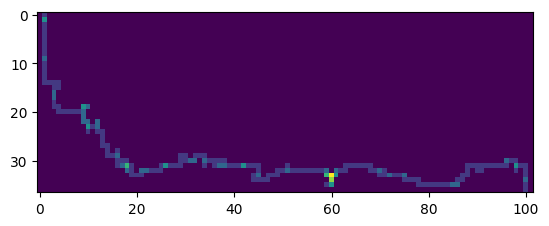

In [64]:
plt.imshow(vis2(stack[3], shape))

(4.0, 17.0) 30


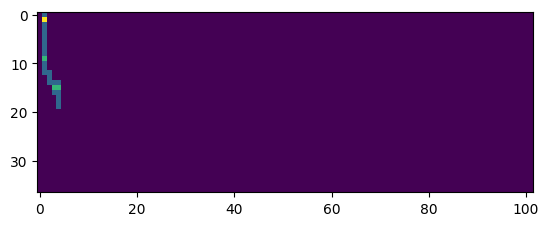

In [53]:
n = 10
dst, minutes, pos, path = stack[n]
print(pos, minutes)
plt.imshow(vis2(path, shape))

In [189]:
shape[1]

8

In [164]:
35 * 20

700